In [1]:
# Import packages
import numpy as np
import cvxpy as cp
import mosek
import time
from sklearn.model_selection import train_test_split

import phi_divergence as phi
import robust_sampling as rs
import dataio
import util

C:\Users\JSTARRE\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The toy model we examine is as follows:

\begin{align}\label{toy_model_2}
    \begin{split}
        \max_{\mathbf{x} \geq \mathbf{0}}\{\mathbf{e}^T \mathbf{x}: \mathbb{P}^*(\mathbf{\xi}\in [-1,1]^{k}: \mathbf{\xi}^T \mathbf{x} \leq 1)\geq \beta\}.
    \end{split}
\end{align}

In [6]:
# Problem specific functions:
def generate_data(random_seed, k, N):
    np.random.seed(random_seed)
    data = np.random.uniform(-1,1,size = (N,k)) # generates N random scenarios    
    return data 

def generate_data_with_nominal(random_seed, k, N):
    data_nominal = np.array([[0] * k])
    np.random.seed(random_seed)
    data = np.random.uniform(-1,1,size = (N-1,k)) # generate N-1 scenarios
    data = np.concatenate((data_nominal,data)) # add nominal case to training data
    return data

def solve_SCP(k, S, time_limit):
    #k = S.shape[1]
    x = cp.Variable(k, nonneg = True)
    if len(S) > 0:
        constraints = [(S @ x) - 1 <= 0, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    else:
        constraints = [cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    try:
        prob.solve(solver=cp.MOSEK, mosek_params = {mosek.dparam.optimizer_max_time: time_limit})
    except cp.error.SolverError:
        return (None, None)
    return (x.value, prob.value)

def uncertain_constraint(S, x):
    return (np.dot(S,x)) - 1

def get_true_prob(x, k):
    return(1/2+1/(2*x[k-1]))
    
def solve_toyproblem_true_prob(beta, k):
    x = cp.Variable(k, nonneg = True)
    constraints = [(1-2*beta)*x[k-1] + 1 >= 0, cp.sum(x[0:(k-1)]) <= x[k-1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

In [8]:
# Set parameter values
random_seed = 1
alpha = 0.01
beta = 0.90
k = 10
N_train = 250
N_test = 250
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 2
numeric_precision = 1e-6 # To correct for floating-point math operations

In [9]:
# Get generated data
#N_campi = util.determine_campi_N_min(k, beta, alpha)
#N_train = N_campi

N_total = N_train + N_test

data = generate_data(random_seed, k, N_total)
data_train, data_test = train_test_split(data, train_size=(N_train/N_total), random_state=random_seed)

In [10]:
time_limit_search = 1*60 # in seconds (time provided to search algorithm)
time_limit_mosek = 10*60 # in seconds (for larger MIP / LP solves)
time_limit_solve = 5*60 # in seconds (for individuals solves of SCP)
max_nr_solutions = 1000 # for easy problems with long time limits, we may want extra restriction
add_remove_threshold = 0.00 # This determines when randomness is introduced in add/removal decision
use_tabu = False # Determines whether the tabu list are used in the search

add_strategy = 'random_vio'
remove_strategy = 'random_active'
clean_strategy = (1000, 'all_inactive')


(runtime, num_iter, solutions, 
 best_sol, pareto_solutions) = rs.gen_and_eval_alg(data_train, data_test, beta, alpha, time_limit_search, time_limit_solve, 
                                                   max_nr_solutions, add_strategy, remove_strategy, clean_strategy, 
                                                   add_remove_threshold, use_tabu, 
                                                   par, phi_div, phi_dot, numeric_precision,
                                                   solve_SCP, uncertain_constraint, random_seed)


In [ ]:
runtime

In [ ]:
num_iter

In [11]:
len(solutions)

398

In [12]:
dataio.print_solution_info(best_sol)

obj: 1.3506825372048783
lb_train: 0.8858897931777515
lb_test: 0.9013110713635349
time_found: 34.223313093185425
scenario_set: [0, 18, 28, 31, 55, 68, 82, 99, 147, 207, 243]


In [13]:
x_true, obj_true = solve_toyproblem_true_prob(beta, k)
obj_alg = best_sol['obj']
obj_gap_true =  100*(obj_true - obj_alg)/obj_true
obj_gap_true

9.954497510911319

In [14]:
# Determine optimal solution given data_test
runtime, opt_x, opt_sum_y, opt_obj, opt_lb = util.compute_opt_given_data(alpha, beta, par, phi_div, phi_dot, data_test, time_limit_mosek)
obj_alg = best_sol['obj']
obj_gap_opt = 100*(opt_obj - obj_alg)/opt_obj
obj_gap_opt

KeyboardInterrupt: 

In [ ]:
for i,sol in enumerate(solutions):
    if i<=7:
        Z_arr = data_train[sol['scenario_set']]
        true_prob = get_true_prob(sol['sol'], k)
        if i == 0:
            dataio.plot_iter(i, data_train, Z_arr, sol['sol'], sol['obj'], 
                             sol['p_train'], sol['lb_train'], true_prob,
                             True, "png", True, N_train, alpha, beta)
        else:
            dataio.plot_iter(i, data_train, Z_arr, sol['sol'], sol['obj'], 
                             sol['p_train'], sol['lb_train'], true_prob,
                             True, "png", False, N_train, alpha, beta)
        
            dataio.plot_iter(i, data_test, None, sol['sol'], sol['obj'], 
                             sol['p_test'], sol['lb_test'], true_prob,
                             True, "png", False, N_test, alpha, beta)
    else:
        break

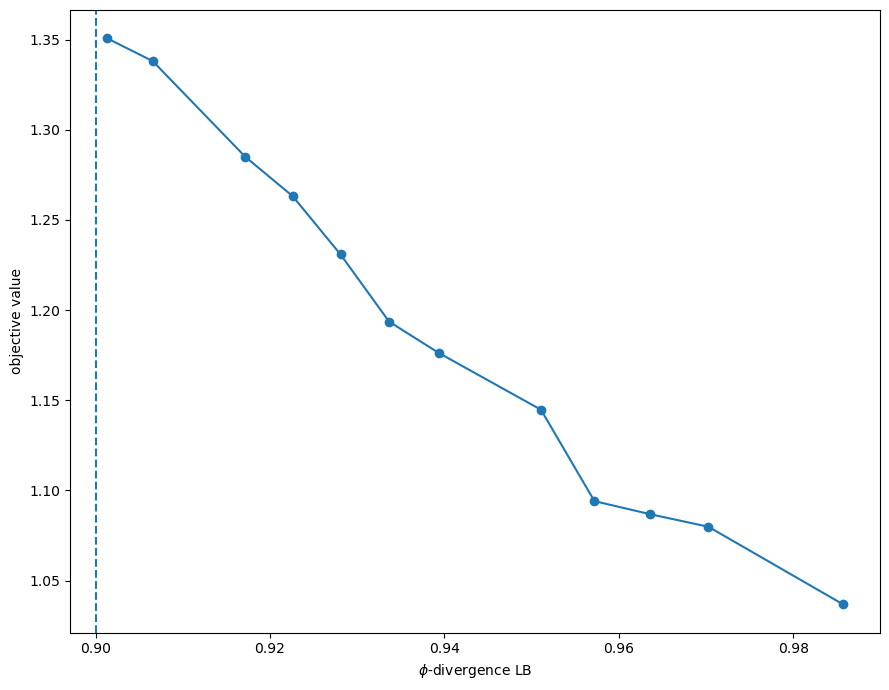

In [15]:
dataio.plot_pareto_curve(pareto_solutions, beta, None, None, None, None)

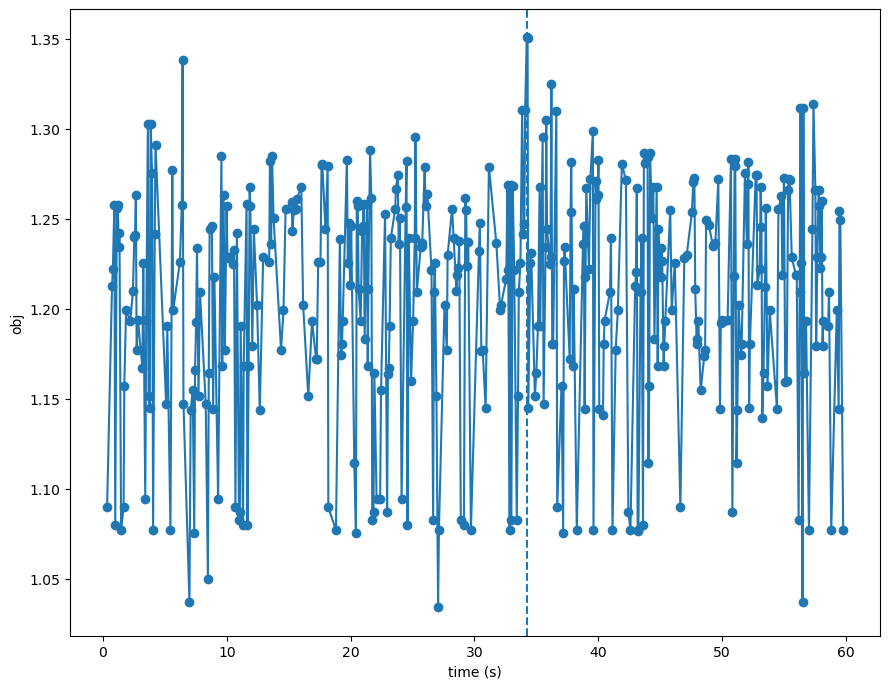

In [16]:
dataio.plot_obj_over_time(solutions, best_sol, None, None, None, None)

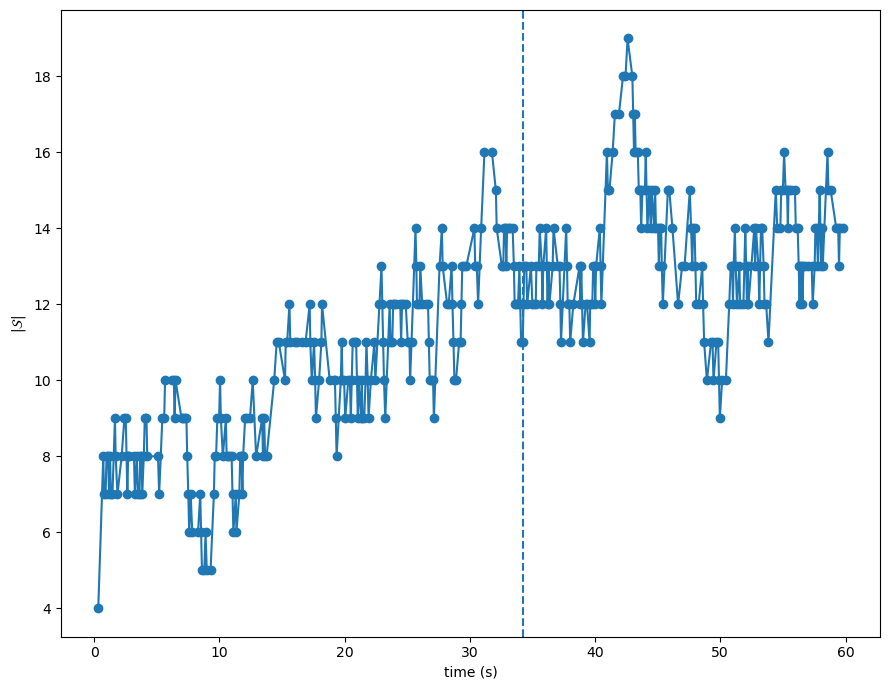

In [17]:
dataio.plot_size_set_over_time(solutions, best_sol, None, None, None, None)

In [ ]:
# Plot final solution found by algorithm
name = 'Strategy: '+ str(add_strategy)
save_plot = False
plot_type = "eps"
show_legend = True
Z_values = data_train[best_sol['scenario_set']]
dataio.plot_solution(name, data_train, Z_values, best_sol['sol'], 
              best_sol['obj'], best_sol['lb_test'], save_plot, plot_type, show_legend, N, alpha, beta)

In [ ]:
# Compute optimal solution with true probability constraint
prob_true = beta
[x_true, obj_true] = solve_toyproblem_true_prob(prob_true, k)
constr = uncertain_constraint(data_test, x_true)
vio = constr[constr>(0+numeric_precision)]   
p_vio = len(vio)/N_train
p = np.array([1-p_vio, p_vio])
r = phi_dot/(2*N_test)*scipy.stats.chi2.ppf(1-alpha, 1)
lb = rs.compute_lb(p, r, par, phi_div)
print(p)
print(lb)
print(obj_true)

In [ ]:
name = "TrueProb="+str(prob_true)
save_plot = False
plot_type = "eps"
show_legend = True
dataio.plot_solution(name, data_test, None, x_true, obj_true, lb, save_plot, plot_type, show_legend, N, alpha, beta)

In [ ]:
# Determine optimal solution given data_test
runtime, opt_x, opt_sum_y, opt_obj, opt_lb = util.compute_opt_given_data(alpha, beta, par, phi_div, data_test, time_limit_mosek)

In [ ]:
runtime

In [ ]:
# Plot optimal solution given data_test
name = 'Opt_given_test_data'
save_plot = False
plot_type = "eps"
show_legend = True
dataio.plot_solution(name, data_test, None, opt_x, opt_obj, opt_lb, save_plot, plot_type, show_legend, N, alpha, beta)

In [ ]:
# Compute solution via Campi method
data = generate_data(k, N_campi)
runtime, campi_x, campi_obj, campi_true_prob, Z_arr = util.solve_with_campi_N(alpha, beta, numeric_precision, data, time_limit_mosek)

In [ ]:
# Plot Campi solution
name = 'Campi method'
save_plot = False
plot_type = "eps"
show_legend = True
dataio.plot_solution(name, data, Z_arr, campi_x, campi_obj, 0, save_plot, plot_type, show_legend, N, alpha, beta)

# The following cells are used to obtain output and write to latex tables

In [18]:
output_file_name = 'new_output_data'

headers = ['$k$', 'seed', '$n_{\mathcal{X}}$',
           'Obj.~(RS)', 'Obj.~(TP)', 'Gap TP.~(\%)', 
           'Obj.~($\mathcal{D}^{\\text{test}}_{N_2}$)', 'Gap $\mathcal{D}^{\\text{test}}_{N_2}$ (\%)',
           'Time', '$|\mathcal{X}|$']

# Write headers to .txt file
with open(r'output/headers_'+output_file_name+'.txt','w+') as f:
    f.write(str(headers))

output_data = {}

# Variable parameter values
k_settings = [2]#, 10, 100]#, 1000]
random_seed_settings = [i for i in range(1, 2)]
n_sol_settings = [1, 100, 500, 1000, 5000, 10000]

# Fixed parameter values
N_total = 500
p_train = 0.5
alpha = 0.01
beta = 0.90

# LB-related parameters
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 2
numeric_precision = 1e-6 # To correct for floating-point math operations

# RS-related parameters
time_limit_search = 15*60
time_limit_solve = 5*60 # in seconds
max_nr_solutions = 10000 # for easy problems with long time limits, we may want extra restriction
add_strategy = 'random_vio'
remove_strategy = 'random_any'
clean_strategy = (30000, 'random_inactive')
add_remove_threshold = 0.0range0 #0.10 controls the ambiguity around adding/removing
use_tabu = False

N_train = round(p_train * N_total)
N_test = N_total - N_train

run_count = 0
for k in k_settings:
    
    # Compute true opt
    x_true, obj_true = solve_toyproblem_true_prob(beta, k)
    
    for random_seed in random_seed_settings:  
        data = generate_data(random_seed, k, N_total)
        data_train, data_test = train_test_split(data, train_size=(N_train/N_total), random_state=random_seed)

        # compute opt given data_test
        runtime_opt, x_opt, sum_y, obj_opt, p_min_opt = util.compute_opt_given_data(alpha, beta, par, phi_div, phi_dot, 
                                                                               data_test, time_limit_solve)
        
            
        # Gen and eval algorithm
        (runtime, num_iter, solutions, 
         best_sol, pareto_solutions) = rs.gen_and_eval_alg(data_train, data_test, beta, alpha, time_limit_search, time_limit_solve, 
                                                           max_nr_solutions, add_strategy, remove_strategy, clean_strategy, 
                                                           add_remove_threshold, use_tabu,  
                                                           par, phi_div, phi_dot, numeric_precision,
                                                           solve_SCP, uncertain_constraint, random_seed)


        for i,n_sol in enumerate(n_sol_settings):
            if i == 0 and len(solutions) == 0:
                output_data[(k, random_seed, n_sol)] = [np.nan,
                                                         obj_true,
                                                         np.nan,
                                                         obj_opt,
                                                         np.nan,
                                                         runtime,
                                                         0]
                break

            elif i == 0 or (i > 0 and len(solutions) > n_sol_settings[i-1]):

                sub_solutions = solutions[0:n_sol]
                time = sub_solutions[-1]['time']
                best_in_sub_sol = {'sol': None}
                for sol_info in sub_solutions:
                    obj = sol_info['obj']
                    lb = sol_info['lb_test']
                    if best_in_sub_sol['sol'] is None or (best_in_sub_sol['lb_test'] < beta and lb > best_in_sub_sol['lb_test']):
                        best_in_sub_sol = sol_info
                    elif ((lb >= beta and obj > best_in_sub_sol['obj']) 
                          or (lb > best_in_sub_sol['lb_test'] and obj >= best_in_sub_sol['obj'])):
                        best_in_sub_sol = sol_info

                obj_rs = best_in_sub_sol['obj']
                obj_gap_true = 100*(obj_true - obj_rs)/obj_true
                obj_gap_opt = 100*(obj_opt - obj_rs)/obj_opt

                output_data[(k, random_seed, n_sol)] = [obj_rs,
                                                         obj_true,
                                                         obj_gap_true,
                                                         obj_opt,
                                                         obj_gap_opt,
                                                         time,
                                                         len(sub_solutions)]


        output_file_name = 'new_output_data'
        with open(r'output/'+output_file_name+'.txt','w+') as f:
            f.write(str(output_data))

        run_count += 1
        print("Completed run: " + str(run_count))

Completed run: 1


In [ ]:
output_data_str = {}
for i,res in output_data.items():
    res_str = []
    for i2,el in enumerate(res):
        if i2 < 5:
            if np.isnan(el):
                res_str.append('-')
            else:
                res_str.append(f'{round(el,2):.2f}') 
        elif i2 == 5:
            res_str.append(f'{round(el,0):.0f}') 
        else:
            res_str.append(el)
    
    output_data_str[i] = res_str

In [ ]:
headers = ['$k$', 'seed', 'remove strategy', '$n_{\mathcal{X}}$',
           'Obj.~(RS)', 'Obj.~(TP)', 'Gap TP.~(\%)', 
           'Obj.~($\mathcal{D}^{\\text{test}}_{N_2}$)', 'Gap $\mathcal{D}^{\\text{test}}_{N_2}$ (\%)',
           'Time', '$|\mathcal{X}|$']

In [ ]:
dataio.write_output_to_latex(4, headers, output_data_str)

In [ ]:
output_file_name = 'new_output'

In [ ]:
# Write headers + output to .txt file
with open(r'output/headers_'+output_file_name+'.txt','w+') as f:
    f.write(str(headers))

# with open(r'output/'+output_file_name+'.txt','w+') as f:
#     f.write(str(output_data))

In [ ]:
output_file_name = 'new_N=100_random_data_random_splits'

In [ ]:
# Read from .txt file
file_path = 'output/'+output_file_name+'.txt'
dic = ''
with open(file_path,'r') as f:
         for i in f.readlines():
            dic=i #string
output_data_read = eval(dic)

In [ ]:
output_data = output_data_read
output_data

In [ ]:
random_seed_data_settings = [i for i in range(1, 7)]
df = pd.DataFrame({key: pd.Series(val) for key, val in output_data.items() if (key[0] == 25
                                                                               and key[1] == 75
                                                                               and key[2] == 1)})

df

In [ ]:
num_test_feas_found = sum(df.iloc[6,:])
num_test_feas_found

In [ ]:
df_feas = df.loc[:,df.iloc[3,:] >= 0.9]
df_feas.empty

In [ ]:
import pandas as pd

k = 1000
beta = 0.9
N_total_settings = [100]
p_train_settings = [0.25, 0.5, 0.75]
random_seed_data_settings = [i for i in range(1, 7)]
random_seed_split_settings = [i for i in range(1, 11)]

output_data_agg = {}
for N_total in N_total_settings:
    for p_train in p_train_settings:
        
        N_train = round(p_train * N_total)
        N_test = N_total - N_train
        
        df = pd.DataFrame({key: pd.Series(val) for key, val in output_data.items() if (key[0] == N_train
                                                                                       and key[1] == N_test
                                                                                       and key[2] in random_seed_data_settings)})
        df = df.astype(float)
        df_agg = df.agg(["mean","std"], axis="columns")

        df_feas = df.loc[:,df.iloc[3,:] >= beta]
        df_feas_agg = df_feas.agg(["mean","std"], axis="columns")

        prob_FF = sum(df.iloc[3,:] >= beta) / len(df.columns)
        true_prob_FF = sum(df.iloc[4,:] >= beta) / len(df.columns)

        avg_obj = df_agg.loc[0,'mean']
        std_obj = df_agg.loc[0,'std']

        if prob_FF > 0:
            avg_obj_F = df_feas_agg.loc[0, 'mean']
            std_obj_F = df_feas_agg.loc[0, 'std']
            avg_gap_F = df_feas_agg.loc[1, 'mean']
            std_gap_F = df_feas_agg.loc[1, 'std']
        else:
            avg_obj_F = 0
            std_obj_F = 0
            avg_gap_F = 0
            std_gap_F = 0

        avg_lb_train = df_agg.loc[2,'mean']
        std_lb_train = df_agg.loc[2,'std']
        avg_lb_test = df_agg.loc[3,'mean']
        std_lb_test = df_agg.loc[3,'std']
        avg_true_prob = df_agg.loc[4,'mean']
        std_true_prob = df_agg.loc[4,'std']
        
        avg_num_test_feas_found = df_agg.loc[6,'mean']
        std_num_test_feas_found = df_agg.loc[6,'std']
        
        avg_time_spent = df_agg.loc[8,'mean']
        std_time_spent = df_agg.loc[8,'std']

        li = []
        li.append(f'{prob_FF:.2f}')
        li.append(f'{true_prob_FF:.2f}')
        #li.append(f'{round(avg_obj,3):.3f}' + " ("+f'{round(std_obj,3):.3f}'+")")
        if prob_FF > 0:
            li.append(f'{round(avg_obj_F,3):.3f}' + " ("+f'{round(std_obj_F,3):.3f}'+")")
            li.append(f'{round(avg_gap_F,3):.3f}' + " ("+f'{round(std_gap_F,3):.3f}'+")")
        else:
            li.append("-")
            li.append("-")
        li.append(f'{round(avg_lb_train,3):.3f}' + " ("+f'{round(std_lb_train,3):.3f}'+")")
        li.append(f'{round(avg_lb_test,3):.3f}' + " ("+f'{round(std_lb_test,3):.3f}'+")")
        li.append(f'{round(avg_true_prob,3):.3f}' + " ("+f'{round(std_true_prob,3):.3f}'+")")
        li.append(f'{round(avg_num_test_feas_found,1):.1f}' + " ("+f'{round(std_num_test_feas_found,1):.1f}'+")")
        li.append(f'{round(avg_time_spent,1):.1f}' + " ("+f'{round(std_time_spent,1):.1f}'+")")

        output_data_agg[(N_train, N_test, 'Single Split Run')] = li
        
        
        count_FF = 0
        count_true_FF = 0
        best_obj = []
        best_gap = []
        lb_train = []
        lb_test = []
        true_prob = []
        num_test_feas_found = []
        time_spent = []
        
        for random_seed_data in random_seed_data_settings:
            df = pd.DataFrame({key: pd.Series(val) for key, val in output_data.items() if (key[0] == N_train
                                                                                       and key[1] == N_test
                                                                                       and key[2] == random_seed_data)})
            
            if sum(df.iloc[3,:] >= beta) > 0:
                count_FF += 1
            if sum(df.iloc[4,:] >= beta) > 0:
                count_true_FF += 1
                
            df_feas = df.loc[:,df.iloc[3,:] >= beta]
            #df_feas_agg = df_feas.agg(["mean","std","max", "min"], axis="columns")
            if not df_feas.empty:
                best_i = df_feas.idxmax(axis=1)[0]
                best_obj.append(df_feas.loc[0, best_i])
                best_gap.append(df_feas.loc[1, best_i])
                lb_train.append(df_feas.loc[2, best_i])
                lb_test.append(df_feas.loc[3, best_i])
                true_prob.append(df_feas.loc[4, best_i])
            
            num_test_feas_found.append(sum(df.iloc[6,:]))
            time_spent.append(sum(df.iloc[8,:]))
            
        prob_FF = count_FF / len(random_seed_data_settings)
        true_prob_FF = count_true_FF / len(random_seed_data_settings)
        avg_obj_F = np.mean(best_obj)
        std_obj_F = np.std(best_obj)
        avg_gap_F = np.mean(best_gap)
        std_gap_F = np.std(best_gap)
        avg_lb_train = np.mean(lb_train)
        std_lb_train = np.std(lb_train)
        avg_lb_test = np.mean(lb_test)
        std_lb_test = np.std(lb_test)
        avg_true_prob = np.mean(true_prob)
        std_true_prob = np.std(true_prob)
        avg_num_test_feas_found = np.mean(num_test_feas_found)
        std_num_test_feas_found = np.std(num_test_feas_found)
        avg_time_spent = np.mean(time_spent)
        std_time_spent = np.std(time_spent)
        
        li = []
        li.append(f'{prob_FF:.2f}')
        li.append(f'{true_prob_FF:.2f}')
        #li.append(f'{round(avg_obj,3):.3f}' + " ("+f'{round(std_obj,3):.3f}'+")")
        if prob_FF > 0:
            li.append(f'{round(avg_obj_F,3):.3f}' + " ("+f'{round(std_obj_F,3):.3f}'+")")
            li.append(f'{round(avg_gap_F,3):.3f}' + " ("+f'{round(std_gap_F,3):.3f}'+")")
        else:
            li.append("-")
            li.append("-")
        li.append(f'{round(avg_lb_train,3):.3f}' + " ("+f'{round(std_lb_train,3):.3f}'+")")
        li.append(f'{round(avg_lb_test,3):.3f}' + " ("+f'{round(std_lb_test,3):.3f}'+")")
        li.append(f'{round(avg_true_prob,3):.3f}' + " ("+f'{round(std_true_prob,3):.3f}'+")")
        li.append(f'{round(avg_num_test_feas_found,1):.1f}' + " ("+f'{round(std_num_test_feas_found,1):.1f}'+")")
        li.append(f'{round(avg_time_spent,1):.1f}' + " ("+f'{round(std_time_spent,1):.1f}'+")")
        
        output_data_agg[(N_train, N_test, 'Best of 10 Split Runs')] = li

In [ ]:
headers_agg = ['$N_{train}$', '$N_{test}$', 'Strategy',
               'Prob.~FF', 'True Prob.~FF', 'Obj.~(Feas)', 'Gap (\%)', '$LB_{train}$', '$LB_{test}$', 'True Prob.',
              '\# FF (test)', 'Time']

dataio.write_output_to_latex(3, headers_agg, output_data_agg)

In [ ]:
count_FF

In [ ]:
# To plot histograms for random seed output
# Read from .txt file
output_file_name = 'new_output'
file_path = 'output/'+output_file_name+'.txt'
dic = ''
with open(file_path,'r') as f:
         for i in f.readlines():
            dic=i #string
output_data_read = eval(dic)

df = pd.DataFrame.from_dict(output_data_read, orient='index')
#li1 = [col for col in df.columns if 'add + improve' == col[1]]

df2 = pd.DataFrame({key: pd.Series(val) for key, val in output_data_read.items() if key[1] == 'add + improve + remove'})
obj2 = df2.iloc[0,:].astype(float)

title = 'Distribution of best found solution objective for random add + improve + remove'# for $\beta = 0.95$, $\alpha=10^{-6}$, $N_{1} = 1,000$, $N_{2} = 10,000$ and time limit $\mathcal{L} = 1$ minute'
dataio.plot_hist(obj2, 'Gap (%)', 'Frequency', title, 20, 0.75)